In [7]:
from brian2 import *
import brian2.numpy_ as np
prefs.codegen.target = 'numpy'
import timeit
start_scope()
#Implementing the independent CaT current.

duration = 100*ms
#Parameters
C = 1*ufarad
V0 = -65*mV
temp = 34
gCaTmax = 0.001*siemens
Cai = 50 * nmole
Cao = 2 * mmole
q10CaT = 5
a0mCaT = 0.04/ms
a0hCaT = 0.015/ms
zetamCaT = 2/mV
zetahCaT = 3.5/mV
vhalfmCaT = -28*mV
vhalfhCaT = -75*mV
gmmCaT = 0.1
gmhCaT = 0.6
f = ((25/293.15)*(temp + 273.15))*mV/2

@check_units(z=1, result=1)    
def efun(z):
    if (np.absolute(z) < 0.0001): 
        return 1 - z/2
    else:
        return z/(exp(z) - 1)
    
@check_units(V=volt, result=1)
def nu(V):
    return V / f


@check_units(V=volt, result=volt)
def ghk(V):
    return -f * (1 - (Cai / Cao) * exp(nu(V))) * efun(nu(V))


eqs = Equations('''
                    dV/dt = (ICaT + I)/C : volt
                    ICaT = gCaT*ghk(V) : amp (constant over dt)
                    gCaT = gCaTmax*mCaT*mCaT*hCaT : siemens
                    dmCaT/dt = (infmCaT - mCaT)/taumCaT : 1
                    dhCaT/dt = (infhCaT - hCaT)/tauhCaT : 1
                    infmCaT = alpmCaT/(alpmCaT+betmCaT) : 1
                    infhCaT = alphCaT/(alphCaT+bethCaT) : 1
                    alpmCaT = 0.2*(mV**-1)*(-V+19.26*mV)/(exp((-V+19.26*mV)/(10.0*mV))-1) : 1
                    alphCaT = 10**-6*exp(-V/(16.26*mV)) : 1
                    alpmtCaT = exp(0.0378*zetamCaT*(V-vhalfmCaT)) : 1
                    betmCaT = 0.009*exp(-V/(22.03*mV)) : 1
                    bethCaT = 1/(exp((-V+29.79*mV)/(10*mV))+1) : 1
                    betmtCaT = exp(0.0378*zetamCaT*gmmCaT*(V-vhalfmCaT)) : 1
                    taumCaT = betmtCaT/(qtCaT*a0mCaT*(1+alpmtCaT)) : second
                    tauhCaT = bethCaT/(a0hCaT*(1+alphCaT)) : second       
                    qtCaT = q10CaT ** ((temp - 25) / 10) : 1
                    I : amp               
                    ''')

group = NeuronGroup(1, eqs, threshold='V > -40*mV', refractory='V > -40*mV', method='rk2')
M = StateMonitor(group, variables=True, record=True)

store()

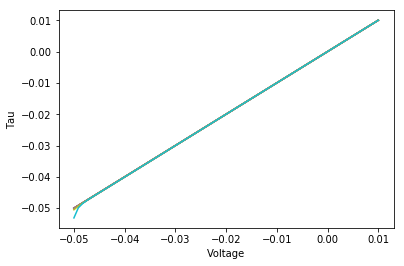

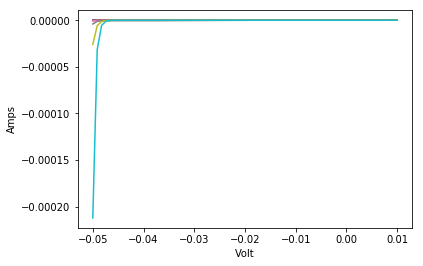

In [8]:

# Plot tau and the channel current for different voltages
voltages = np.linspace(-50, 10, 70) * mV
vs = []
Is = []
for volt in voltages:
    # Restore the original state of the network
    restore()
    group.V = volt
    alpm0 = 0.2*(mV**-1)*(-volt+19.26*mV)/(exp((-volt+19.26*mV)/(10.0*mV))-1)
    betm0 = 0.009*exp(-volt/(22.03*mV))
    alph0 = 10**-6*exp(-volt/(16.26*mV))
    beth0 = 1/(exp((-volt+29.79*mV)/(10*mV))+1)
    group.mCaT = alpm0/(alpm0+betm0)
    group.hCaT = alph0/(alph0+beth0)
    # Run it with the new value of tau
    run(1 * ms)
    vs.append(M.V[0])
    Is.append(M.ICaT[0])

figure(1)
plot(voltages, vs)
xlabel('Voltage')
ylabel('Tau');

figure(2)
plot(voltages, Is)
xlabel('Volt')
ylabel('Amps');
show()
